# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Structured Streaming** </center>
---

**Date**: Nov, 2025

**Student Name**: Diego Orozco Alvarado

**Professor**: Pablo Camarillo Ramirez

# Introduction

Objective: To build a data pipeline in Python using Apache Spark for data consumption in continuous mode, transformation, and persistence, with the objective of addressing a practical problem. 

En este notebook se busca mejorar la implementacion de la abterior entrega usando kafka. Esta anterior entrega se fue "batch_processing" y se trato de diseñar e implementar un pipeline por lotes que simula la
ingesta y procesamiento de telemetría tipo Waze. El objetivo es:
- Generar datos (simulados) de usuarios/dispositivos que reportan coordenadas, alertas y solicitudes de ruta.
- Procesar/limpiar y manejar los datos con PySpark 
  (transformaciones: normalización, agregados, joins).
- Se usara PostgreSQL para permitir persistiencia en resultados como sistema relacional para consultas analíticas y downstream.
### Problema:
Los conductores dependen de aplicaciones de navegación como Waze o maps para decidir las mejores rutas en tiempo real. Sin embargo, estas aplicaciones deben procesar grandes volúmenes de datos generados por miles de usuarios simultáneamente, incluyendo información de ubicación (GPS), velocidad, tráfico, accidentes, obras, cierres de calles, etc.

El problema principal sucede al recolectar, transformar y almacenar de forma eficiente ya que estos son datos masivos necesarios ya que proveen información útil y actualizada a todos los usuarios. 
Por este motivo el objetivo de este proyecto es diseñar e implementar un pipeline de datos batch que procese eventos generados por los usuarios de Waze (por decir alguna), limpie y transforme la información, y la persista en una base de datos relacional para su análisis posterior.


In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

spark = (
    SparkSession.builder 
        .appName("proy waze kafka")
        .master("local[*]")
        .config("spark.jars", "/opt/spark/work-dir/jars/postgresql-42.7.8.jar")
        .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0")
        .config("spark.ui.port", "4040")
        .getOrCreate()
)

sc = spark.sparkContext
sc.setLogLevel("ERROR")

spark.conf.set("spark.sql.shuffle.partitions", "5")


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9f034f36-688f-4701-8e3c-3162ab04e606;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;4.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.13;4.0.0 in central
	found org.apache.kafka#kafka-clients;3.9.0 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.7 in central
	found org.slf4j#slf4j-api;2.0.16 in central
	found org.apache.hadoop#hadoop-client-runtime;3.4.1 in central
	found org.apache.hadoop#hadoop-client-api;3.4.1 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.scala-lang.modules#scala-parallel-collections_2.13;1.2.0

## Producer (30 points)

Using the application and dataset used in the batch_processing Notebook, you need to write a producer script in python to generate the information in continuous mode. The producer could produce data in one of the two options:

Files (reference  lab 07)

Kafka topic (reference lab 10 ) <- Usare Kafka

#### producer file: "waze_kafka_producer.py"
```bash
python waze_kafka_producer.py kafka:9093 waze_diego_orozco
```
```bash
python3 waze_kafka_producer.py kafka:9093 waze_diego_orozco
```

# Consumer

## Dataset and Stream creation (10 points)
This section should contain the code to create a stream using Spark Structured Streaming API to consume the data in continuous mode from the selected stream channel (files or kafka).  The information you need to consume in this section should contain the schema generation (with the SparkUtils class) and the correct format and reading options.




In [2]:
# Waze schema 
waze_schema = StructType([
    StructField("event_id", StringType(), True),
    StructField("device_id", StringType(), True),
    StructField("user_id", StringType(), True),
    StructField("timestamp", StringType(), True),
    StructField("lat", DoubleType(), True),
    StructField("lon", DoubleType(), True),
    StructField("speed_kmh", DoubleType(), True),
    StructField("heading", DoubleType(), True),
    StructField("event_type", StringType(), True),
    StructField("alert_type", StringType(), True),
    StructField("route_points", StringType(), True)
])


In [3]:
# Kafka stram

kafka_df = (
    spark.readStream
        .format("kafka")
        .option("kafka.bootstrap.servers", "kafka:9093")
        .option("subscribe", "waze_diego_orozco")
        .load()
)
kafka_df.printSchema()


root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



## Transformations and Actions (15 points)
In this section, you need to provide the code to clean and process data (create new columns, aggregate, run joins, etc.). In this section is NOT expected to have any action.



In [4]:
parsed = kafka_df.select(from_json(col("value").cast("string"), waze_schema).alias("data")).select("data.*")

#timestamp 
transformed = parsed.withColumn("timestamp_ts", to_timestamp(col("timestamp")))
transformed = transformed.withWatermark("timestamp_ts", "2 minutes")

#columnas de partición
transformed = transformed.withColumn("year", year(col("timestamp_ts"))) \
                         .withColumn("month", month(col("timestamp_ts"))) \
                         .withColumn("day", dayofmonth(col("timestamp_ts"))) \
                         .withColumn("hour", hour(col("timestamp_ts")))

#categoría de velocidad
transformed = transformed.withColumn(
    "speed_category",
    when(col("speed_kmh").isNull(), lit("unknown"))
    .when(col("speed_kmh") < 30, lit("low"))
    .when((col("speed_kmh") >= 30) & (col("speed_kmh") < 70), lit("medium"))
    .otherwise(lit("high"))
)

print("Transformed schema:")
transformed.printSchema()


Transformed schema:
root
 |-- event_id: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- speed_kmh: double (nullable = true)
 |-- heading: double (nullable = true)
 |-- event_type: string (nullable = true)
 |-- alert_type: string (nullable = true)
 |-- route_points: string (nullable = true)
 |-- timestamp_ts: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- speed_category: string (nullable = false)



## Persistence Data (15 points)
Once information is transformed, you need to document the process of persistence data in files using at least one vertical partition (partitionBy).  



In [49]:
from pathlib import Path
import traceback

OUTPUT_DIR = "../../data/data_proy/data_proy_waze_kafka"
CHECKPOINT_DIR = "/opt/spark/work-dir/spark/checkpoints/waze_kafka"
Path(OUTPUT_DIR).parent.mkdir(parents=True, exist_ok=True)

CHECKPOINT_DIR = "/opt/spark/work-dir/chk/waze_pg"

print(f"output folder: {OUTPUT_DIR}")

output folder: ../../data/data_proy/data_proy_waze_kafka


In [51]:
import time
query_csv = (
    transformed.writeStream
        .trigger(processingTime="5 seconds")
        .partitionBy("day")
        .outputMode("append")
        .format("csv")
        .option("header", "true")
        .option("path", OUTPUT_DIR)
        .option("checkpointLocation", CHECKPOINT_DIR)
        .start()
)
print("Streaming to started...")
print("Runing for 60 seconds.")
time.sleep(60)

print("Stopping stream...")
query.stop() # Nota para presentar: 
# esta accion (query.stop()) al probar me dio "ERROR FileFormatWriter" debido a que el batch en el que estaba se termina ignorando 
# esto se puede ver en un incio al volver a ejecutar debido al CHECKPOINT.
print("streaming stopped.")


Streaming to started...
Runing for 60 seconds.


25/11/18 03:16:32 ERROR FileFormatWriter: Aborting job 79fa2741-f77e-4eb5-9d14-0167d0577fd5.
org.apache.spark.SparkFileNotFoundException: [BATCH_METADATA_NOT_FOUND] Unable to find batch file:/opt/spark/work-dir/data/data_proy/data_proy_waze_kafka/_spark_metadata/9.compact. SQLSTATE: 42K03
	at org.apache.spark.sql.errors.QueryExecutionErrors$.batchMetadataFileNotFoundError(QueryExecutionErrors.scala:1741)
	at org.apache.spark.sql.execution.streaming.HDFSMetadataLog.applyFnToBatchByStream(HDFSMetadataLog.scala:197)
	at org.apache.spark.sql.execution.streaming.CompactibleFileStreamLog.applyFnInBatch(CompactibleFileStreamLog.scala:210)
	at org.apache.spark.sql.execution.streaming.CompactibleFileStreamLog.foreachInBatch(CompactibleFileStreamLog.scala:196)
	at org.apache.spark.sql.execution.streaming.CompactibleFileStreamLog.$anonfun$compact$3(CompactibleFileStreamLog.scala:238)
	at scala.runtime.java8.JFunction1$mcVJ$sp.apply(JFunction1$mcVJ$sp.scala:18)
	at scala.collection.immutable.Numer

Stopping stream...
streaming stopped.


In [52]:
!pwd
!ls -lah ../../data/data_proy/data_proy_waze_kafka

/opt/spark/work-dir/final_project/streaming_processing
total 772K
drwxr-xr-x  7 root root  224 Nov 18 03:13  .
drwxr-xr-x  5 root root  160 Nov 18 02:10  ..
drwxr-xr-x 14 root root  448 Nov 18 03:16 'day=18'
drwxr-xr-x 14 root root  448 Nov 18 03:16 'day=19'
-rw-r--r--  1 root root 761K Nov 18 02:16  part-00000-a0675e03-e980-4373-b40d-84b06836cb95-c000.csv
-rw-r--r--  1 root root 6.0K Nov 18 02:16  .part-00000-a0675e03-e980-4373-b40d-84b06836cb95-c000.csv.crc
drwxr-xr-x 16 root root  512 Nov 18 03:16  _spark_metadata


## Power BI Dashboard (10 points)
With the files generated in the persistence section, you should create a Dashboard using Power BI to summarize and visualize the information you processed in the Data Pipeline



Nota: Para la mostrar mas datos en el BI volvi a correr el codigo pero sin .partitionBy("day") para tener mas datos en el csv.
Ya en un entorno real se deberia configurar el BI para que lea multiples archivos.

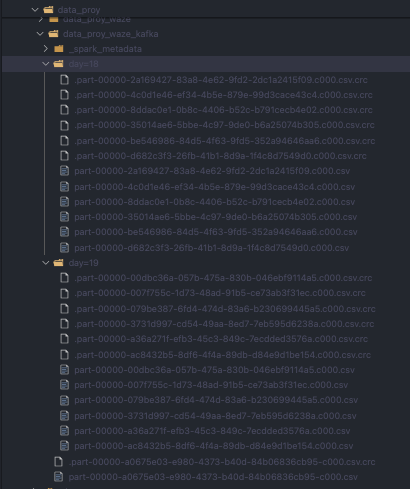

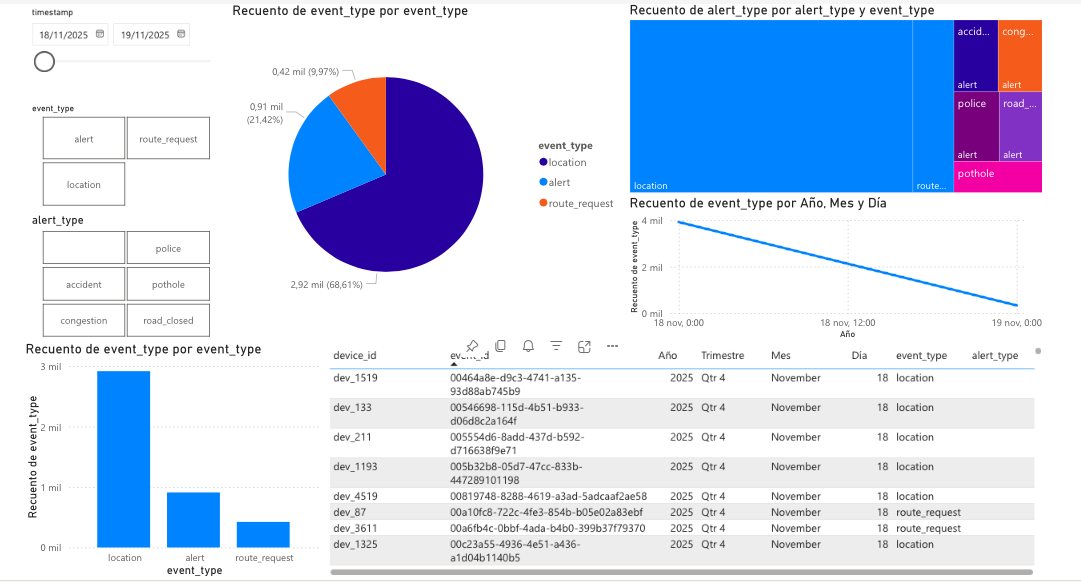